# ResNet50 Image Classifier

**This notebook should run correctly both in colab and on jupyter.**
- Uses stratified sampling (making sure all classes have same ratio in all sets).
- Uses metadata from **'data/encoded_columns_data'**.
- Uses images from folder **'directly_processed_images'**.

## **Setup**

In [ ]:
import sys
on_colab = 'google.colab' in sys.modules
if on_colab:
  print("Running notebook on google colab")
  # use ice cream to conveniently print stuff
  !pip install icecream
else:
  print("Notebook not running on google colab")

Running notebook on google colab


In [ ]:
# imports
from icecream import ic
import pandas as pd
import numpy as np
import torch
import time
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
import timeit
import torchvision
# import torchsummary
from torchvision import transforms, datasets
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
# from torchsummary import summary
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns

# to save session
import pickle

from tqdm import tqdm

In [ ]:
if on_colab:
  from google.colab import drive
  drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print("PyTorch version:")
print(torch.__version__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using {} device".format(device))

PyTorch version:
2.2.1+cu121
Using cuda device


## Define paths to image folder & metadata

In [ ]:
# paths
if on_colab:
  metadata_path = '/content/drive/MyDrive/CDS Project/data/encoded_final_data.csv'
  images_path = '/content/drive/MyDrive/CDS Project/directly_processed_images'
else:
  metadata_path = '../data/encoded_final_data.csv'
  images_path = '../directly_processed_images'

In [ ]:
metadata_df = pd.read_csv(metadata_path)
metadata_df

,image_id,age,target,localization,gender
0,ISIC_5136612,65.0,0,4,0
1,ISIC_0031002,65.0,0,5,0
2,ISIC_0026875,35.0,1,5,1
3,ISIC_0024371,70.0,2,1,0
4,ISIC_0027263,85.0,3,4,0
...,...,...,...,...,...
1395,ISIC_0027531,65.0,5,1,0
1396,ISIC_0025691,50.0,5,4,1
1397,ISIC_0028381,55.0,6,0,1
1398,ISIC_0033254,15.0,4,4,0


In [ ]:
num_images = len([file for file in os.listdir(images_path) if os.path.isfile(os.path.join(images_path, file))])
print("Number of images: ", num_images)

Number of images:  1400


## Train test split (Stratified Sampling)

In [ ]:
# Split data in features and target:
X = metadata_df  # features
y = metadata_df['target']  # target

# Splitting into train, test, and validation sets with stratified sampling
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=0, stratify=y_temp)

ic(len(X_train), len(X_test), len(X_val))

ic| len(X_train): 1120, len(X_test): 140, len(X_val): 140


(1120, 140, 140)

In [ ]:
# Resizing to 224x224, some transformations/augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomCrop(224, padding=4),
    # transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2), # random adjustments
    # transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),  # for blurry images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # standard normalization
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Define CustomDataset function

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, metadata, transform=None):
        self.metadata = metadata
        self.images_path = images_path
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        img_id = self.metadata.iloc[idx, 0]  # Get image ID of sample using the metadata index
        img_name = os.path.join(self.images_path, f'processed_{img_id}.jpg')  # name of image files
        if not os.path.exists(img_name):
            raise FileNotFoundError(f"Image file not found: {img_name}")

        image = Image.open(img_name)
        row = metadata_df[metadata_df['image_id'] == img_id]
        label = row.iloc[0]['target']

        if self.transform is not None:
            image = self.transform(image)

        # # extract demographic features
        # age = torch.tensor(self.metadata.iloc[idx, 1])
        # localization = torch.tensor(self.metadata.iloc[idx, 3])
        # gender = torch.tensor(self.metadata.iloc[idx, 4])

        return image, label

## Define train, validation and test datasets/dataloaders

In [ ]:
# custom datasets
train_dataset = CustomDataset(metadata=X_train, transform=train_transform)
val_dataset = CustomDataset(metadata=X_val, transform=val_transform)
test_dataset = CustomDataset(metadata=X_test, transform=val_transform)

# Create data loaders (optimized for faster loading)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, persistent_workers=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8, persistent_workers=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=8, persistent_workers=True, pin_memory=True)

# check
ic(len(train_dataset), len(val_dataset), len(test_dataset))

ic| len(train_dataset): 1120
    len(val_dataset): 140
    len(test_dataset): 140


(1120, 140, 140)

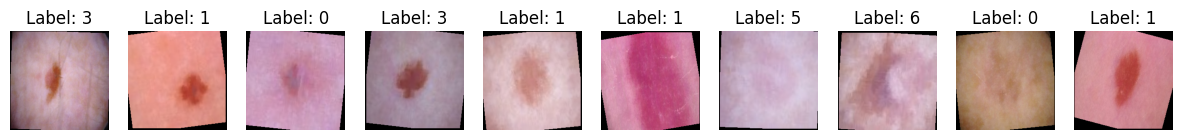

In [ ]:
# Get a single batch of data from the train_loader
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Convert the images tensor to numpy format for plotting
images = images.numpy()

# Plot some random images from the batch
num_images_to_show = 10  # Number of images you want to display

# Set up the figure
fig, axes = plt.subplots(1, num_images_to_show, figsize=(15, 3))

for i in range(num_images_to_show):
    # Convert image to the range [0, 1] and transpose to HWC format
    img = np.transpose(images[i], (1, 2, 0))
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)

    # Plot the image
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f'Label: {labels[i]}')

# Show the figure
plt.show()

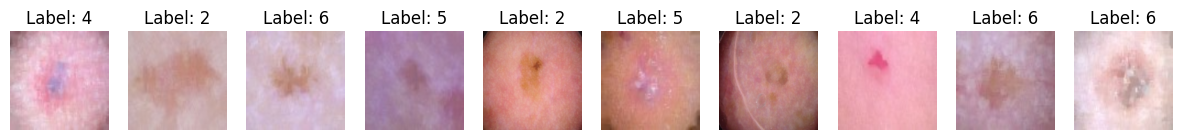

In [ ]:
# Get a single batch of data from the train_loader
data_iter = iter(val_loader)
images, labels = next(data_iter)

# Convert the images tensor to numpy format for plotting
images = images.numpy()

# Plot some random images from the batch
num_images_to_show = 10  # Number of images you want to display

# Set up the figure
fig, axes = plt.subplots(1, num_images_to_show, figsize=(15, 3))

for i in range(num_images_to_show):
    # Convert image to the range [0, 1] and transpose to HWC format
    img = np.transpose(images[i], (1, 2, 0))
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)

    # Plot the image
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(f'Label: {labels[i]}')

# Show the figure
plt.show()

## ResNet50 + modified last layer

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights

model_resnet = models.resnet50(pretrained=True)

#### Modify last layer
- adjust to the appropriate number of output classes (7)

In [ ]:
num_features = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_features, 7)  # 7 classes
# see new model structure
# print(model_resnet)

#### Adam optimizer + CEL

In [ ]:
# Loss function: CEL
criterion = nn.CrossEntropyLoss()

# Optimizer: Adam
optimizer = torch.optim.Adam(model_resnet.parameters(), lr=0.001, )

### Training

In [ ]:
model_resnet.to(device)
criterion.to(device)

CrossEntropyLoss()

In [ ]:
# Training for one epoch

def train_model(model, criterion, optimizer, train_loader, val_loader):

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in tqdm(train_loader):
        labels = labels.long()
        labels = labels.to(device)
        images = images.to(device)
        optimizer.zero_grad()
        # forward propagation, i.e. get predictions
        outputs = model(images)
        # calculate loss and backpropagate to model paramters:
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_acc = correct_train / total_train

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            labels=labels.long()
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_acc = correct_val / total_val

    return train_loss, val_loss, train_acc, val_acc

In [ ]:
# specify epochs to train
total_epochs = 30

tl = []
vl = []
ta = []
va = []

for epoch in range(total_epochs):
    start_time = time.time()  # Record start time

    train_loss, val_loss, train_acc, val_acc = train_model(model_resnet, criterion, optimizer, train_loader, val_loader)
    tl.append(train_loss)
    vl.append(val_loss)
    ta.append(train_acc)
    va.append(val_acc)

    elapsed_time = time.time() - start_time  # Calculate elapsed time

    print(f"Epoch {epoch+1}/{total_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Elapsed Time: {elapsed_time:.2f} seconds")

100%|██████████| 35/35 [00:12<00:00,  2.87it/s]


Epoch 1/30, Train Loss: 1.8708, Train Acc: 0.3107, Val Loss: 7.7747, Val Acc: 0.2214, Elapsed Time: 13.28 seconds


100%|██████████| 35/35 [00:12<00:00,  2.88it/s]


Epoch 2/30, Train Loss: 1.5470, Train Acc: 0.4196, Val Loss: 1.8233, Val Acc: 0.3643, Elapsed Time: 13.27 seconds


100%|██████████| 35/35 [00:12<00:00,  2.88it/s]


Epoch 3/30, Train Loss: 1.3648, Train Acc: 0.4848, Val Loss: 2.2058, Val Acc: 0.4071, Elapsed Time: 13.36 seconds


100%|██████████| 35/35 [00:12<00:00,  2.89it/s]


Epoch 4/30, Train Loss: 1.3167, Train Acc: 0.4705, Val Loss: 1.6386, Val Acc: 0.4000, Elapsed Time: 13.48 seconds


100%|██████████| 35/35 [00:12<00:00,  2.88it/s]


Epoch 5/30, Train Loss: 1.1838, Train Acc: 0.5384, Val Loss: 1.3898, Val Acc: 0.5071, Elapsed Time: 13.57 seconds


100%|██████████| 35/35 [00:11<00:00,  2.93it/s]


Epoch 6/30, Train Loss: 1.1711, Train Acc: 0.5429, Val Loss: 1.6994, Val Acc: 0.4286, Elapsed Time: 13.47 seconds


100%|██████████| 35/35 [00:12<00:00,  2.85it/s]


Epoch 7/30, Train Loss: 1.1203, Train Acc: 0.5839, Val Loss: 2.1428, Val Acc: 0.4286, Elapsed Time: 13.74 seconds


100%|██████████| 35/35 [00:12<00:00,  2.86it/s]


Epoch 8/30, Train Loss: 1.0689, Train Acc: 0.5982, Val Loss: 1.6203, Val Acc: 0.5071, Elapsed Time: 13.70 seconds


100%|██████████| 35/35 [00:12<00:00,  2.86it/s]


Epoch 9/30, Train Loss: 1.0094, Train Acc: 0.6312, Val Loss: 1.0983, Val Acc: 0.6286, Elapsed Time: 13.67 seconds


100%|██████████| 35/35 [00:12<00:00,  2.87it/s]


Epoch 10/30, Train Loss: 0.9020, Train Acc: 0.6589, Val Loss: 1.4497, Val Acc: 0.4929, Elapsed Time: 13.55 seconds


100%|██████████| 35/35 [00:12<00:00,  2.88it/s]


Epoch 11/30, Train Loss: 0.9524, Train Acc: 0.6330, Val Loss: 1.3861, Val Acc: 0.5786, Elapsed Time: 13.59 seconds


100%|██████████| 35/35 [00:12<00:00,  2.90it/s]


Epoch 12/30, Train Loss: 0.9824, Train Acc: 0.6330, Val Loss: 1.2304, Val Acc: 0.5929, Elapsed Time: 13.57 seconds


100%|██████████| 35/35 [00:12<00:00,  2.88it/s]


Epoch 13/30, Train Loss: 0.8244, Train Acc: 0.6875, Val Loss: 1.3692, Val Acc: 0.6143, Elapsed Time: 13.59 seconds


100%|██████████| 35/35 [00:12<00:00,  2.88it/s]


Epoch 14/30, Train Loss: 0.9177, Train Acc: 0.6429, Val Loss: 1.3598, Val Acc: 0.5500, Elapsed Time: 13.61 seconds


100%|██████████| 35/35 [00:12<00:00,  2.86it/s]


Epoch 15/30, Train Loss: 0.8301, Train Acc: 0.7009, Val Loss: 1.1076, Val Acc: 0.5786, Elapsed Time: 13.79 seconds


100%|██████████| 35/35 [00:12<00:00,  2.90it/s]


Epoch 16/30, Train Loss: 0.8337, Train Acc: 0.6964, Val Loss: 1.5580, Val Acc: 0.5714, Elapsed Time: 13.65 seconds


100%|██████████| 35/35 [00:12<00:00,  2.89it/s]


Epoch 17/30, Train Loss: 0.7443, Train Acc: 0.7170, Val Loss: 1.7628, Val Acc: 0.5071, Elapsed Time: 13.62 seconds


100%|██████████| 35/35 [00:12<00:00,  2.88it/s]


Epoch 18/30, Train Loss: 0.7368, Train Acc: 0.7179, Val Loss: 1.2822, Val Acc: 0.5357, Elapsed Time: 13.69 seconds


100%|██████████| 35/35 [00:12<00:00,  2.88it/s]


Epoch 19/30, Train Loss: 0.7114, Train Acc: 0.7455, Val Loss: 1.4467, Val Acc: 0.5929, Elapsed Time: 13.71 seconds


100%|██████████| 35/35 [00:12<00:00,  2.87it/s]


Epoch 20/30, Train Loss: 0.6855, Train Acc: 0.7438, Val Loss: 1.4999, Val Acc: 0.5571, Elapsed Time: 13.72 seconds


100%|██████████| 35/35 [00:11<00:00,  2.96it/s]


Epoch 21/30, Train Loss: 0.7039, Train Acc: 0.7420, Val Loss: 1.8435, Val Acc: 0.5429, Elapsed Time: 13.25 seconds


100%|██████████| 35/35 [00:12<00:00,  2.86it/s]


Epoch 22/30, Train Loss: 0.6740, Train Acc: 0.7562, Val Loss: 1.3334, Val Acc: 0.6214, Elapsed Time: 13.80 seconds


100%|██████████| 35/35 [00:12<00:00,  2.87it/s]


Epoch 23/30, Train Loss: 0.6541, Train Acc: 0.7580, Val Loss: 1.5759, Val Acc: 0.5857, Elapsed Time: 13.65 seconds


100%|██████████| 35/35 [00:12<00:00,  2.87it/s]


Epoch 24/30, Train Loss: 0.6122, Train Acc: 0.7714, Val Loss: 1.5487, Val Acc: 0.4929, Elapsed Time: 13.63 seconds


100%|██████████| 35/35 [00:12<00:00,  2.88it/s]


Epoch 25/30, Train Loss: 0.5624, Train Acc: 0.7884, Val Loss: 1.5757, Val Acc: 0.4929, Elapsed Time: 13.65 seconds


100%|██████████| 35/35 [00:12<00:00,  2.90it/s]


Epoch 26/30, Train Loss: 0.5921, Train Acc: 0.7688, Val Loss: 1.4812, Val Acc: 0.5500, Elapsed Time: 13.62 seconds


100%|██████████| 35/35 [00:11<00:00,  2.93it/s]


Epoch 27/30, Train Loss: 0.5770, Train Acc: 0.7982, Val Loss: 1.5207, Val Acc: 0.6286, Elapsed Time: 13.36 seconds


100%|██████████| 35/35 [00:12<00:00,  2.82it/s]


Epoch 28/30, Train Loss: 0.5154, Train Acc: 0.7955, Val Loss: 1.1242, Val Acc: 0.6214, Elapsed Time: 13.90 seconds


100%|██████████| 35/35 [00:12<00:00,  2.84it/s]


Epoch 29/30, Train Loss: 0.5181, Train Acc: 0.8170, Val Loss: 1.0320, Val Acc: 0.6786, Elapsed Time: 13.81 seconds


100%|██████████| 35/35 [00:12<00:00,  2.87it/s]


Epoch 30/30, Train Loss: 0.5415, Train Acc: 0.8071, Val Loss: 1.3963, Val Acc: 0.5143, Elapsed Time: 13.73 seconds


In [ ]:
# extra epochs

for epoch in range(10):
    start_time = time.time()  # Record start time

    train_loss, val_loss, train_acc, val_acc = train_model(model_resnet, criterion, optimizer, train_loader, val_loader)
    tl.append(train_loss)
    vl.append(val_loss)
    ta.append(train_acc)
    va.append(val_acc)

    elapsed_time = time.time() - start_time  # Calculate elapsed time

    print(f"Epoch {30+epoch+1}/{40}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Elapsed Time: {elapsed_time:.2f} seconds")

100%|██████████| 35/35 [00:12<00:00,  2.87it/s]


Epoch 31/40, Train Loss: 0.4842, Train Acc: 0.8196, Val Loss: 1.2102, Val Acc: 0.6643, Elapsed Time: 13.26 seconds


100%|██████████| 35/35 [00:12<00:00,  2.74it/s]


Epoch 32/40, Train Loss: 0.4413, Train Acc: 0.8429, Val Loss: 1.9723, Val Acc: 0.5429, Elapsed Time: 13.86 seconds


100%|██████████| 35/35 [00:12<00:00,  2.74it/s]


Epoch 33/40, Train Loss: 0.5038, Train Acc: 0.8089, Val Loss: 1.4807, Val Acc: 0.5429, Elapsed Time: 13.81 seconds


100%|██████████| 35/35 [00:12<00:00,  2.83it/s]


Epoch 34/40, Train Loss: 0.4880, Train Acc: 0.8241, Val Loss: 1.5532, Val Acc: 0.6357, Elapsed Time: 13.44 seconds


100%|██████████| 35/35 [00:12<00:00,  2.84it/s]


Epoch 35/40, Train Loss: 0.3996, Train Acc: 0.8607, Val Loss: 1.1875, Val Acc: 0.6143, Elapsed Time: 13.35 seconds


100%|██████████| 35/35 [00:12<00:00,  2.89it/s]


Epoch 36/40, Train Loss: 0.4241, Train Acc: 0.8509, Val Loss: 1.2082, Val Acc: 0.6500, Elapsed Time: 13.19 seconds


100%|██████████| 35/35 [00:12<00:00,  2.89it/s]


Epoch 37/40, Train Loss: 0.3759, Train Acc: 0.8670, Val Loss: 1.3382, Val Acc: 0.6500, Elapsed Time: 13.23 seconds


100%|██████████| 35/35 [00:12<00:00,  2.88it/s]


Epoch 38/40, Train Loss: 0.3616, Train Acc: 0.8723, Val Loss: 1.3571, Val Acc: 0.6429, Elapsed Time: 13.22 seconds


100%|██████████| 35/35 [00:11<00:00,  2.92it/s]


Epoch 39/40, Train Loss: 0.3590, Train Acc: 0.8741, Val Loss: 1.1879, Val Acc: 0.7071, Elapsed Time: 13.06 seconds


100%|██████████| 35/35 [00:11<00:00,  2.92it/s]


Epoch 40/40, Train Loss: 0.3321, Train Acc: 0.8714, Val Loss: 1.5383, Val Acc: 0.6000, Elapsed Time: 13.23 seconds


In [ ]:
# # extra epochs

# for epoch in range(10):
#     start_time = time.time()  # Record start time

#     train_loss, val_loss, train_acc, val_acc = train_model(model_resnet, criterion, optimizer, train_loader, val_loader)
#     tl.append(train_loss)
#     vl.append(val_loss)
#     ta.append(train_acc)
#     va.append(val_acc)

#     elapsed_time = time.time() - start_time  # Calculate elapsed time

#     print(f"Epoch {50+epoch+1}/{60}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Elapsed Time: {elapsed_time:.2f} seconds")

### Visualisation

In [ ]:
# visualisation function
def plotResults():
    plt.figure(figsize=(10,6))
    epovec=range(len(ta))
    plt.plot(epovec,ta,epovec,tl,epovec,va,epovec,vl,linewidth=3)
    plt.legend(('Training Accuracy','Training Loss','Validation Accuracy','Validation Loss'))

    # make the graph understandable:
    plt.title("Losses and Accuracies")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.show()

In [ ]:
# plot loss function
def plotLosses():
    plt.figure(figsize=(10,6))
    epovec=range(len(tl))
    plt.plot(epovec,tl,epovec,vl,linewidth=3)
    plt.legend(('Training Loss', 'Validation Loss'))

    # make the graph understandable:
    plt.title("Training and Validation Losses")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss")
    plt.show()

In [ ]:
# plot accuracies function
def plotAccuracies():
    plt.figure(figsize=(10,6))
    epovec=range(len(ta))
    plt.plot(epovec,ta,epovec,va,linewidth=3)
    plt.legend(('Training Accuracy', 'Validation Accuracy'))

    # make the graph understandable:
    plt.title("Training and Validation Accuracies")
    plt.xlabel("Epoch #")
    plt.ylabel("Accuracy")
    plt.show()

In [ ]:
# evaluate model function
def evaluate_model(model, criterion, data_loader):
    model.eval()
    loss = 0.0
    correct = 0
    total = 0

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.long()
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss += criterion(outputs, labels).item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    loss /= len(data_loader.dataset)
    accuracy = correct / total

    return loss, accuracy, all_predictions, all_labels

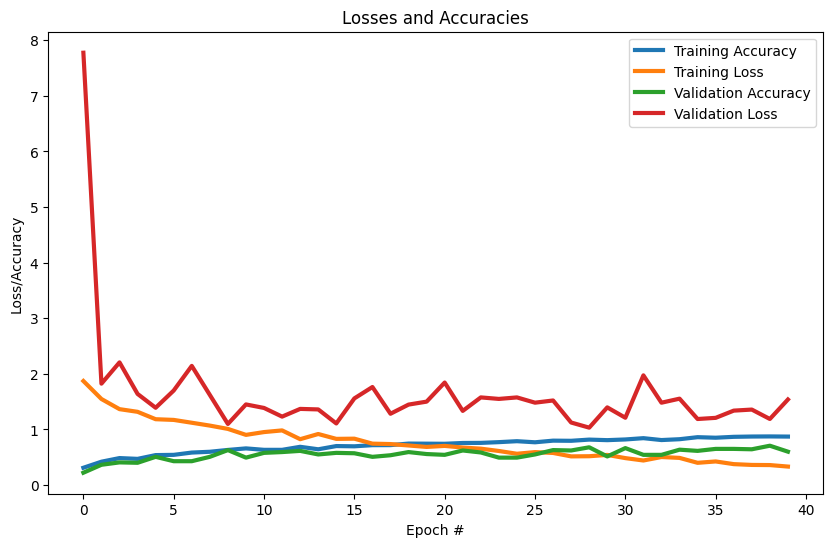

In [ ]:
plotResults()

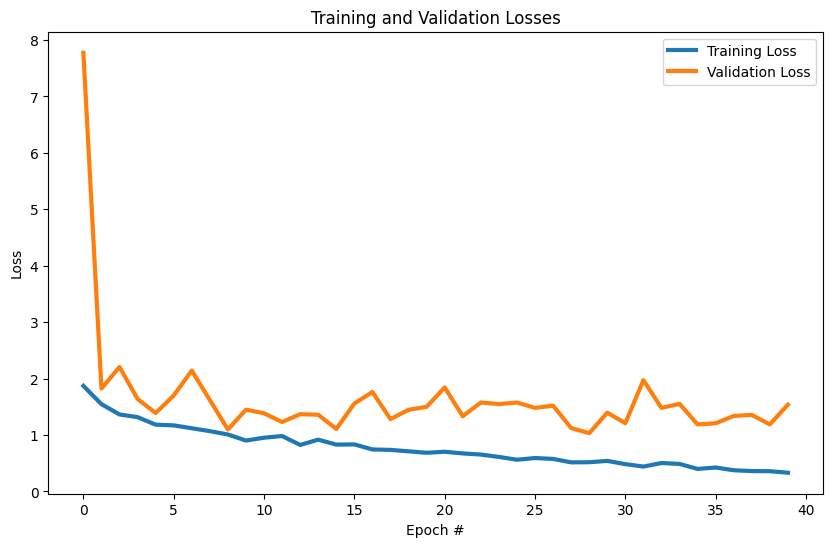

In [ ]:
# plot losses separately
plotLosses()

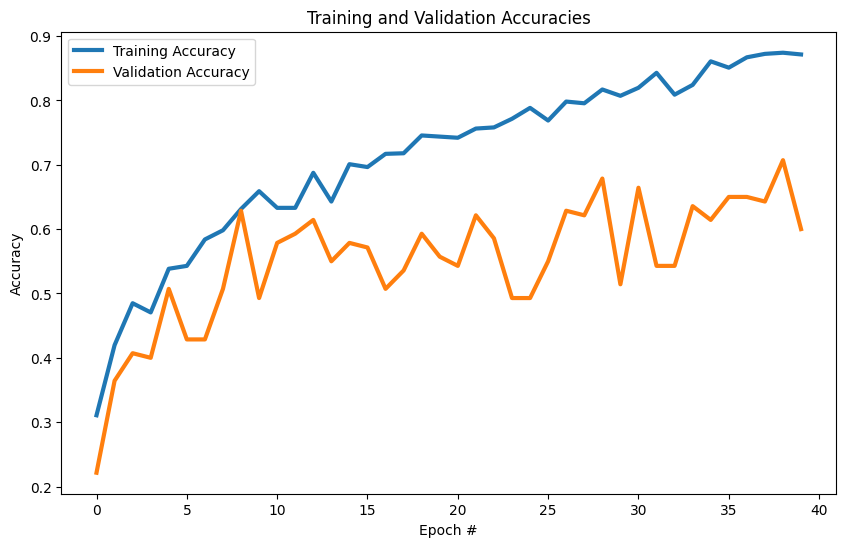

In [ ]:
# plot accuracies separately
plotAccuracies()

### Evaluation on Test Set

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Evaluate model
test_loss, test_accuracy, all_predictions, all_labels = evaluate_model(model_resnet, criterion, test_loader)

# Compute classification report
report = classification_report(all_labels, all_predictions)
print("Classification Report:\n", report)

# Compute confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:\n", conf_matrix)

# Compute accuracy per class
class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
print("Accuracy per Class:", class_accuracy)
print("Test accuracy: ", test_accuracy)

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.75      0.75        20
           1       0.52      0.60      0.56        20
           2       0.34      0.50      0.41        20
           3       0.58      0.55      0.56        20
           4       0.95      0.90      0.92        20
           5       0.62      0.65      0.63        20
           6       0.78      0.35      0.48        20

    accuracy                           0.61       140
   macro avg       0.65      0.61      0.62       140
weighted avg       0.65      0.61      0.62       140

Confusion Matrix:
 [[15  1  1  0  1  2  0]
 [ 1 12  2  4  0  1  0]
 [ 0  5 10  4  0  0  1]
 [ 1  5  2 11  0  1  0]
 [ 0  0  1  0 18  1  0]
 [ 2  0  4  0  0 13  1]
 [ 1  0  9  0  0  3  7]]
Accuracy per Class: [0.75 0.6  0.5  0.55 0.9  0.65 0.35]
Test accuracy:  0.6142857142857143


### Save model & parameters

In [ ]:
# define saving paths
if on_colab:
  save_to_path = '/content/drive/MyDrive/CDS Project/saved_models/resnet_classifier.pth'
  save_params_path = '/content/drive/MyDrive/CDS Project/saved_models/resnet_classifier_params.pth'
else:
  save_to_path = '../saved_models/resnet_classifier.pth'
  save_params_path = '../saved_models/resnet_classifier_params.pth'

In [ ]:
torch.save(model_resnet, save_to_path)
torch.save(model_resnet.state_dict(), save_params_path)